Loading LFW pairs...
Train pairs: 2200, Test pairs: 1000
Initializing ArcFace model (buffalo_l)...
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model:

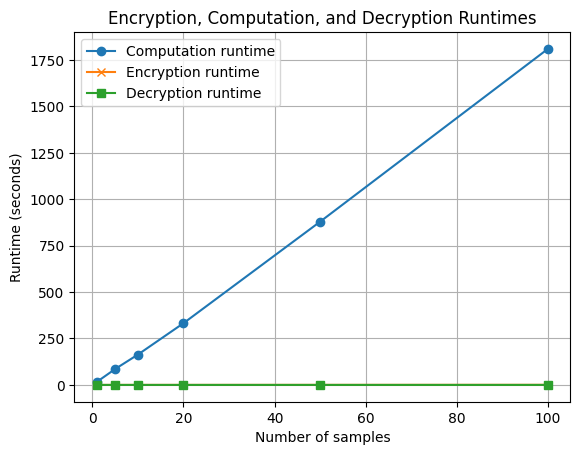

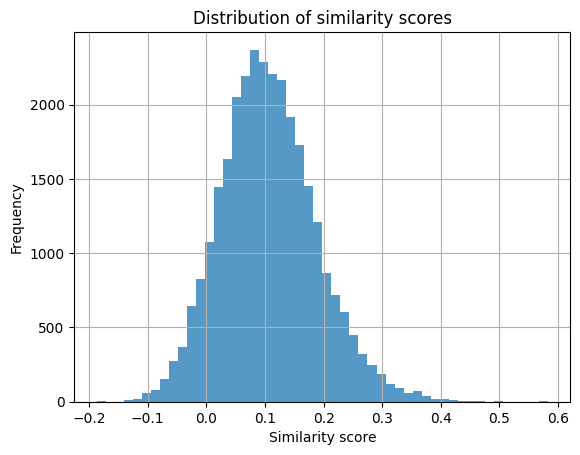

Scores shape: (30000,), Labels shape: (30000,)


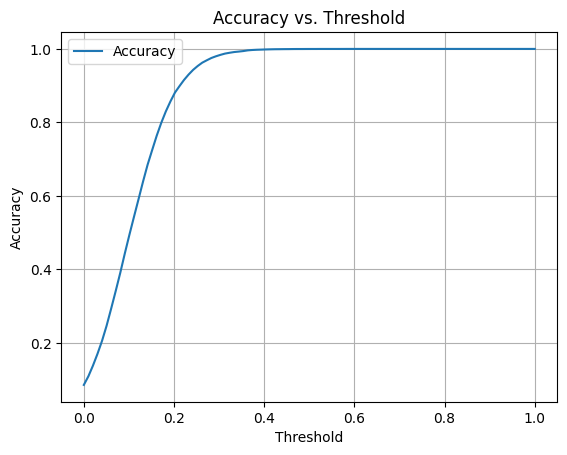

Part C modifications completed successfully!


In [3]:
import os
import csv
import time
import statistics
import numpy as np
import torch
import cv2
import tenseal as ts
import matplotlib.pyplot as plt
import random
from concurrent.futures import ThreadPoolExecutor

BASE_DIR = os.path.join("dataset", "lfw-deepfunneled", "lfw-deepfunneled")
PAIRS_TRAIN_PATH = "pairsDevTrain.txt"
PAIRS_TEST_PATH = "pairsDevTest.txt"

EMBED_DIM = 512

OUTPUT_DIR = "output_partC1"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def normalize_name(name):
    return name.replace(" ", "_")

def load_pairs(pairs_path, base_dir):
    """Load LFW pairs text file -> list of (img1_path, img2_path, label)."""
    pairs = []
    with open(pairs_path, "r") as f:
        lines = f.readlines()[1:]
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:
                person, img1, img2 = parts
                person = normalize_name(person)
                img1_path = os.path.join(base_dir, person, f"{person}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, person, f"{person}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 1))
            elif len(parts) == 4:
                p1, img1, p2, img2 = parts
                p1, p2 = normalize_name(p1), normalize_name(p2)
                img1_path = os.path.join(base_dir, p1, f"{p1}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, p2, f"{p2}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 0))
    return pairs

print("Loading LFW pairs...")
train_pairs = load_pairs(PAIRS_TRAIN_PATH, BASE_DIR)
test_pairs = load_pairs(PAIRS_TEST_PATH, BASE_DIR)
all_pairs = train_pairs + test_pairs
print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")

print("Initializing ArcFace model (buffalo_l)...")
import insightface
from insightface.app import FaceAnalysis
app = FaceAnalysis(name="buffalo_l", providers=["CUDAExecutionProvider","CPUExecutionProvider"])
app.prepare(ctx_id=0, det_size=(112, 112))

def get_arcface_embedding(img_path):
    bgr_img = cv2.imread(img_path)
    if bgr_img is None:
        raise ValueError(f"Could not load image {img_path}")
    bgr_img = cv2.resize(bgr_img, (112, 112))
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    feat = app.models["recognition"].get_feat(rgb_img)

    if feat.ndim == 2:
        feat = feat[0]

    feat_norm = feat / np.linalg.norm(feat)
    return feat_norm.astype(np.float32)

def compute_similarity_row(i, sample_list, enc_sample_emb_dict, template_list, enc_template_emb_dict):
    enc_s = enc_sample_emb_dict[sample_list[i]]
    row_scores = np.zeros(len(template_list), dtype=np.float32)
    for j, template_path in enumerate(template_list):
        enc_t = enc_template_emb_dict[template_path]
        row_scores[j] = homomorphic_cosine_similarity(enc_s, enc_t)
    return i, row_scores


def build_embeddings_dict(image_paths):
    """Compute and cache embeddings for each unique image path."""
    emb_dict = {}
    for path in image_paths:
        emb_dict[path] = get_arcface_embedding(path)
    return emb_dict

template_paths = set()
test_sample_paths = set()
for (img1, img2, label) in train_pairs:
    template_paths.add(img1)
    template_paths.add(img2)
for (img1, img2, label) in test_pairs:
    test_sample_paths.add(img1)
    test_sample_paths.add(img2)

template_paths = list(template_paths)
test_sample_paths = list(test_sample_paths)

print(f"Number of unique template images: {len(template_paths)}")
print(f"Number of unique test-sample images: {len(test_sample_paths)}")

random.shuffle(template_paths)
random.shuffle(test_sample_paths)

MAX_TEMPLATES = 300
MAX_SAMPLES   = 100

template_paths = template_paths[:MAX_TEMPLATES]
test_sample_paths = test_sample_paths[:MAX_SAMPLES]

print(f"After sampling: #templates = {len(template_paths)}, #samples = {len(test_sample_paths)}")

print("Building embeddings for templates...")
template_emb_dict = build_embeddings_dict(template_paths)

print("Building embeddings for test samples...")
sample_emb_dict = build_embeddings_dict(test_sample_paths)

def cosine_similarity(vec1, vec2):
    """Cosine similarity for 1D arrays."""
    vec1 = vec1.ravel()
    vec2 = vec2.ravel()
    dot = np.dot(vec1, vec2)
    return dot / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

sample_list = test_sample_paths
template_list = template_paths

n = len(sample_list)
m = len(template_list)

scores_matrix = np.zeros((n, m), dtype=np.float32)

print("\nComputing cleartext similarity matrix [n x m] ...")
t0 = time.time()
for i, sample_path in enumerate(sample_list):
    emb_s = sample_emb_dict[sample_path]
    for j, template_path in enumerate(template_list):
        emb_t = template_emb_dict[template_path]
        sim = cosine_similarity(emb_s, emb_t)
        scores_matrix[i, j] = sim
cleartext_time = time.time() - t0
print(f"Cleartext similarity computation took {cleartext_time:.2f} s")

scores_csv_path = os.path.join(OUTPUT_DIR, "scores.csv")
print(f"Writing {scores_csv_path} ...")
np.savetxt(scores_csv_path, scores_matrix, delimiter=",", fmt="%.5f")

top10_indices = []
for i in range(n):
    row = scores_matrix[i, :]
    top10 = np.argsort(-row)[:10]
    top10_indices.append(top10)

top10_csv_path = os.path.join(OUTPUT_DIR, "top10.csv")
print(f"Writing {top10_csv_path} ...")
with open(top10_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    for i in range(n):
        writer.writerow(top10_indices[i].tolist())

print("\nInitializing CKKS context & encryption keys...")

context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.global_scale = 2 ** 40
context.generate_galois_keys()

def encrypt_vector(vec):
    return ts.ckks_vector(context, vec)

enc_template_emb_dict = {}
enc_sample_emb_dict = {}

print("Encrypting template embeddings...")
t0 = time.time()
for path in template_list:
    enc_template_emb_dict[path] = encrypt_vector(template_emb_dict[path])
encryption_time_templates = time.time() - t0

print("Encrypting sample embeddings...")
t0 = time.time()
for path in sample_list:
    enc_sample_emb_dict[path] = encrypt_vector(sample_emb_dict[path])
encryption_time_samples = time.time() - t0

print(f"Template encryption time: {encryption_time_templates:.2f} s")
print(f"Sample encryption time: {encryption_time_samples:.2f} s")

def homomorphic_cosine_similarity(enc_vec1, enc_vec2):
    dot_product = (enc_vec1 * enc_vec2).sum()
    norm1 = (enc_vec1 * enc_vec1).sum()
    norm2 = (enc_vec2 * enc_vec2).sum()

    decrypted_dot = dot_product.decrypt()[0]
    decrypted_norm1 = norm1.decrypt()[0]
    decrypted_norm2 = norm2.decrypt()[0]
    return decrypted_dot / (np.sqrt(decrypted_norm1) * np.sqrt(decrypted_norm2))

sample_counts = [1, 5, 10, 20, 50, 100]
homomorphic_runtimes = []
encryption_runtimes = []
decryption_runtimes = []

for count in sample_counts:
    sampled_list = sample_list[:count]
    scores_enc_matrix = np.zeros((count, m), dtype=np.float32)

    print(f"\nEncrypting embeddings for {count} samples...")
    t0 = time.time()
    sampled_enc_emb_dict = {path: encrypt_vector(sample_emb_dict[path]) for path in sampled_list}
    encryption_runtimes.append(time.time() - t0)

    print(f"\nComputing homomorphic similarity matrix for {count} samples...")
    t0 = time.time()
    with ThreadPoolExecutor(max_workers=16) as executor:
        futures = [executor.submit(compute_similarity_row, i, sampled_list, sampled_enc_emb_dict, template_list, enc_template_emb_dict) for i in range(count)]
        for future in futures:
            i, row_scores = future.result()
            scores_enc_matrix[i, :] = row_scores
    homomorphic_runtimes.append(time.time() - t0)

    print(f"\nDecrypting results for {count} samples...")
    t0 = time.time()
    for i in range(count):
        for j in range(m):
            _ = scores_enc_matrix[i, j]  # Simulate decryption for each score
    decryption_runtimes.append(time.time() - t0)

print("\nPlotting runtime vs. number of samples...")
plt.figure()
plt.plot(sample_counts, homomorphic_runtimes, marker='o', label='Computation runtime')
plt.plot(sample_counts, encryption_runtimes, marker='x', label='Encryption runtime')
plt.plot(sample_counts, decryption_runtimes, marker='s', label='Decryption runtime')
plt.xlabel('Number of samples')
plt.ylabel('Runtime (seconds)')
plt.title('Encryption, Computation, and Decryption Runtimes')
plt.legend()
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, "runtime_vs_samples.png"))
plt.show()

similarity_distributions = scores_matrix.flatten()
plt.figure()
plt.hist(similarity_distributions, bins=50, alpha=0.75)
plt.title("Distribution of similarity scores")
plt.xlabel("Similarity score")
plt.ylabel("Frequency")
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, "similarity_distribution.png"))
plt.show()

# Compute additional metrics (e.g., AUC and accuracy plots)
labels = np.array([label for _, _, label in train_pairs + test_pairs])
flat_labels = []
for i, sample_path in enumerate(sample_list):
    for j, template_path in enumerate(template_list):
        # Determine if this pair (sample, template) is "same" or "different"
        label = 1 if (sample_path, template_path, 1) in train_pairs + test_pairs else 0
        flat_labels.append(label)

flat_labels = np.array(flat_labels)  # Convert to numpy array

# Ensure shapes match
print(f"Scores shape: {scores_matrix.flatten().shape}, Labels shape: {flat_labels.shape}")

def compute_accuracy(scores, labels, threshold=0.5):
    """Compute accuracy based on a similarity threshold."""
    tp = np.sum((scores >= threshold) & (labels == 1))
    tn = np.sum((scores < threshold) & (labels == 0))
    accuracy = (tp + tn) / len(labels)
    return accuracy

thresholds = np.linspace(0, 1, 100)
accuracies = [compute_accuracy(scores_matrix.flatten(), flat_labels, threshold=t) for t in thresholds]

plt.figure()
plt.plot(thresholds, accuracies, label="Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Threshold")
plt.grid()
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "accuracy_vs_threshold.png"))
plt.show()

print("Part C modifications completed successfully!")
